In [5]:
import os
import cv2
import random
import shutil
import torchvision.transforms as transforms

from xeception_2x1ch import *
from xeception import *
from googlenetv4 import *
import pandas as pd
import numpy as np
import tqdm


In [14]:
radius_list = []
def concat_origin_img(white_img, black_img):
    white_img = 255 - white_img

    img_sum = np.zeros((white_img.shape[0],white_img.shape[1],3), dtype=np.uint8)
    img_sum[:,:,0] = white_img
    img_sum[:,:,1] = black_img
    
    return img_sum

def find_circles(img_origin):
    try:
        img = img_origin[:,:,1]
        #가우시안필터
        # gaus = cv2.GaussianBlur(img, (5, 5), 7)

        #적응형이진화
        # thres = cv2.adaptiveThreshold(gaus, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 9, 5)
        # thres = cv2.GaussianBlur(thres, (5, 5), 7)
        
        circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 1200, param1 = 250, param2 = 60, minRadius = 720, maxRadius = 800)
    except Exception as e:
        print(e)
        return False, img    
    try:
        if circles is not None:
            for i in circles[0]:
                cx = i[0]
                cy = i[1]
                radius = i[2]
        else:
            print("not finded in black")
            img = img_origin[:,:,0]
            # #가우시안필터
            # gaus = cv2.GaussianBlur(img, (5, 5), 7)

            # #적응형이진화
            # thres = cv2.adaptiveThreshold(gaus, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 9, 5)
            # thres = cv2.GaussianBlur(thres, (5, 5), 7)
            
            circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 1200, param1 = 250, param2 = 60, minRadius = 720, maxRadius = 800)
            if circles is not None:
                for i in circles[0]:
                    cx = i[0]
                    cy = i[1]
                    radius = i[2]
            else:
                print('cannot find circles... in both')
                cx = img_origin.shape[1]//2
                cy = img_origin.shape[0]//2
                radius = 740
    except Exception as e:
        print('fail to find circle!', e)
        cx = img_origin.shape[1]//2
        cy = img_origin.shape[0]//2
        radius = 740

    #이미지 ROI 추출
    margin = 40 # 여백
    s_radius = radius
    x_min = max(0, int(cx - s_radius - margin))  # Ensure x_min is not less than 0
    y_min = max(0, int(cy - s_radius - margin))  # Ensure y_min is not less than 0
    x_max = min(img_origin.shape[1], int(cx + s_radius + margin))  # Ensure x_max does not exceed image width
    y_max = min(img_origin.shape[0], int(cy + s_radius + margin))  # Ensure y_max does not exceed image height

    img_roi = img_origin[y_min:y_max,x_min:x_max]
    if img_roi.size == 0: # If the ROI is empty, provide some error message or handle this case
        return False, img
    else:
        img_roi = cv2.resize(img_roi,(1500,1500))

    return True, img_roi

In [68]:
########## 전처리 테스트 ###################


# 나스에서 조회용
nas_base = r'\\contactlensEB/Home/contactlensEB_backup/'
nas_path = nas_base + '/images_copy/original_images'
nas_path2 = nas_base + '/images_copy2/original_images'
nas_path3 = nas_base + '/images_copy3/original_images'

#조회기간설정
set_date = '20230823'
from_time = '112000'
to_time = '114650'

#몇호기인지
set_machine = nas_path2

#전처리완료된 이미지 저장용 폴더
save_folder = r'E:\claassifier\images_sec_renew\da4076_pre'

# 시작
all_dir_list = os.listdir(set_machine + '/'+ set_date)
target_list = [f for f in all_dir_list if f[8:14] >= from_time and f[8:14] <= to_time]
target_blist = [f for f in target_list if f.split(".jpg")[0][-1] == '1']
print('image_count : ', len(target_blist))


for file in tqdm.tqdm(target_blist):
    file_path = set_machine + '/'+ set_date + '/' + file
    white_path = file_path.replace('1.jpg','0.jpg')
    b_img = cv2.imread(file_path,0)
    w_img = cv2.imread(white_path,0)
    
    concated_img = concat_origin_img(white_img=w_img, black_img=b_img)
    is_success, pic = find_circles(concated_img)

    cv2.imwrite(save_folder+ '/' + file, pic)

KeyboardInterrupt: 

In [18]:
######################### 특정폴더에서 이미지 전처리 테스트
#전처리완료된 이미지 저장용 폴더
image_path = r'E:\images_copy3\temp'
# 나스에서 조회용
# nas_base = r'\\contactlensEB/Home/contactlensEB_backup/'
# nas_path = nas_base + '/images_copy/original_images'
# nas_path2 = nas_base + '/images_copy2/original_images'
# nas_path3 = nas_base + '/images_copy3/original_images'

# image_path = nas_path2 + '/20230905'
save_folder = r'E:\images_copy3\temp_modi'

# 시작
target_blist = [f for f in os.listdir(image_path) if f.split(".jpg")[0][-1] == '1']
print('image_count : ', len(target_blist))

failed_list = []
for file in tqdm.tqdm(target_blist):
    file_path = image_path + '/' + file
    white_path = file_path.replace('1.jpg','0.jpg')
    b_img = cv2.imread(file_path,0)
    w_img = cv2.imread(white_path,0)
    
    concated_img = concat_origin_img(white_img=w_img, black_img=b_img)
    is_success, pic = find_circles(concated_img)

    cv2.imwrite(save_folder+ '/' + file, pic)

image_count :  20


100%|██████████| 20/20 [00:03<00:00,  6.04it/s]

not finded in black


In [8]:
failed_list

[]

In [19]:

class_list = ['good', 'b_edge', 'burr', 'borken', 'b_bubble', 'etc', 'no_lens']


In [20]:
def copy_to_savefolder(img_path_list, result_list, class_list, save_dir):
    for n,result in enumerate(result_list):
        try:
            if True not in result:
                shutil.copy(img_path_list[n], save_dir + '/' + class_list[5]+ '/' + os.path.basename(img_path_list[n]))
            else:
                for i,r in enumerate(result):
                    if r:
                        shutil.copy(img_path_list[n], save_dir + '/' + class_list[i]+ '/' + os.path.basename(img_path_list[n]))
        except:
            shutil.copy(img_path_list[n], save_dir + '/' + class_list[int(result)]+ '/' + os.path.basename(img_path_list[n]))

7번
(256, 1)
(256, 1)
(256, 1)


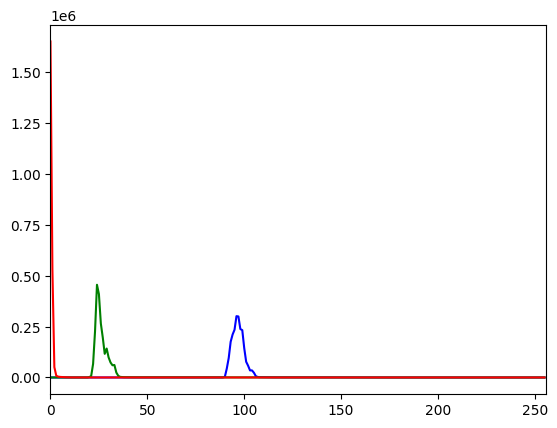

2번


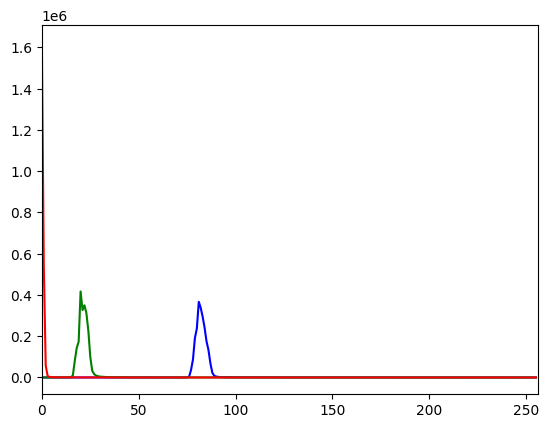

7번-2


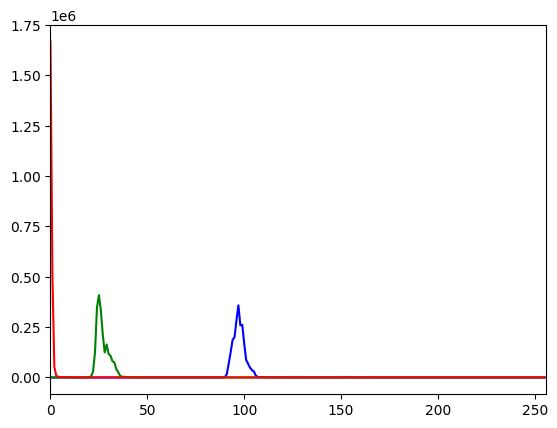

In [34]:
################################# 유사도판정
# img_list = []
# img1 = cv2.imread(base_path + '/' + '20230901155629_1_R_1.jpg')
# img_list.append(img1)
# img2 = cv2.imread(base_path + '/' + '20230901155629_2_R_1.jpg')
# img_list.append(img2)
# img3 = cv2.imread(base_path + '/' + '20230901155754_4_L_1.jpg')
# img_list.append(img3)

# hists = []
# for i, img in enumerate(img_list) :
#     #---① 각 이미지를 HSV로 변환
#     hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
#     #---② H,S 채널에 대한 히스토그램 계산
#     hist = cv2.calcHist([hsv], [0,1], None, [180,256], [0,180,0, 256])
#     #---③ 0~1로 정규화
#     cv2.normalize(hist, hist, 0, 1, cv2.NORM_MINMAX)
#     hists.append(hist)

# methods = {'CORREL' :cv2.HISTCMP_CORREL,             # cv2.HISTCMP_CORREL: 상관관계 (1: 완전 일치, -1: 완전 불일치, 0: 무관계)
#         'CHISQR':cv2.HISTCMP_CHISQR,                 # cv2.HISTCMP_CHISQR: 카이제곱 (0: 완전 일치, 무한대: 완전 불일치)
#         'INTERSECT':cv2.HISTCMP_INTERSECT,           # cv2.HISTCMP_INTERSECT: 교차 (1: 완전 일치, 0: 완전 불일치 - 1로 정규화한 경우)
#         'BHATTACHARYYA':cv2.HISTCMP_BHATTACHARYYA}   # cv2.HISTCMP_BHATTACHARYYA 값이 작을수록 유사한 것으로 판단
# all_compare = []
# for l in range(len(hists)):
#     query = hists[l]
#     part_compare = []
#     for j, (name, flag) in enumerate(methods.items()):
#         print('%-10s'%name, end='\n')
#         feat_compare = []
#         for i, (hist, img) in enumerate(zip(hists, img_list)):
#             #---④ 각 메서드에 따라 img1과 각 이미지의 히스토그램 비교
#             ret = cv2.compareHist(query, hist, flag)
#             if flag == cv2.HISTCMP_INTERSECT: #교차 분석인 경우
#                 ret = ret/np.sum(query)        #비교대상으로 나누어 1로 정규화
#             print("img%d_%d:%7.2f"% (l,i , ret), end='\n')
#             feat_compare.append(ret)
#         part_compare.append(feat_compare)
#     print("\n*****************************************")

#     all_compare.append(part_compare)


# print(all_compare[0][0])
# print(np.array(all_compare).shape)
import matplotlib.pyplot as plt


base_path = r'E:\images_copy3\temp_modi'

img = cv2.imread(base_path + '/' + '20230911093356_2_R_1.jpg')
color = ('b','g','r')
print('7번')
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    print(histr.shape)
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

img = cv2.imread(base_path + '/' + '20230911093356_2_L_1.jpg')
color = ('b','g','r')
print('2번')
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()
print('7번-2')
img = cv2.imread(base_path + '/' + '20230911093345_0_R_1.jpg')
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

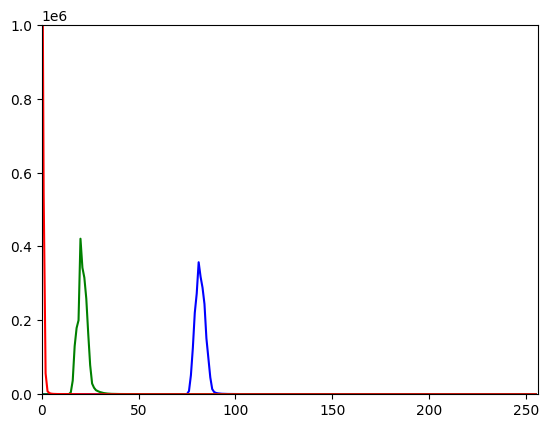

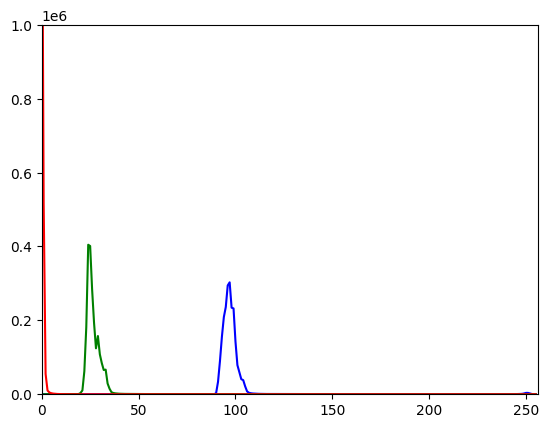

In [60]:
#이미지 오른쪽 왼쪽 히스토그램 평균내기
import matplotlib.pyplot as plt

img_path = r'E:\images_copy3\temp_modi'
img_list = os.listdir(img_path)
img_list = [x for x in img_list if x.endswith(".jpg")]
color = ('b','g','r')

histr_l = np.zeros((3,256, 1))
count_l = 0
histr_r = np.zeros((3, 256, 1))
count_r = 0
for img_file in img_list:
    img = cv2.imread(img_path + '/' + img_file)
    for i,col in enumerate(color):
        histr = cv2.calcHist([img],[i],None,[256],[0,256])
        if img_file.split("_")[2] == 'L':
            histr_l[i] += histr
            count_l += 1/3
        elif img_file.split("_")[2] == 'R':
            histr_r[i] += histr
            count_r += 1/3

for i,col in enumerate(color):
    plt.plot(histr_l[i]/count_l,color = col)
    plt.xlim([0,256])
plt.ylim([0,1000000])
plt.show()

for i,col in enumerate(color):
    plt.plot(histr_r[i]/count_r,color = col)
    
    plt.xlim([0,256])
plt.ylim([0,1000000])
plt.show()

# img = cv2.imread(base_path + '/' + '20230911093356_2_R_1.jpg')
# color = ('b','g','r')
# print('7번')
# for i,col in enumerate(color):
#     histr = cv2.calcHist([img],[i],None,[256],[0,256])
#     print(histr.shape)
#     plt.plot(histr,color = col)
#     plt.xlim([0,256])
# plt.show()

# img = cv2.imread(base_path + '/' + '20230911093356_2_L_1.jpg')
# color = ('b','g','r')
# print('2번')
# for i,col in enumerate(color):
#     histr = cv2.calcHist([img],[i],None,[256],[0,256])
#     plt.plot(histr,color = col)
#     plt.xlim([0,256])
# plt.show()
# print('7번-2')
# img = cv2.imread(base_path + '/' + '20230911093345_0_R_1.jpg')
# color = ('b','g','r')
# for i,col in enumerate(color):
#     histr = cv2.calcHist([img],[i],None,[256],[0,256])
#     plt.plot(histr,color = col)
#     plt.xlim([0,256])
# plt.show()

In [23]:
%load_ext autoreload
%autoreload 2
import test
import numpy as np
import time

base_path = r'E:\images_copy3\temp_modi'
save_dir = r'E:\images_copy3\temp_modi\testest'

for clsss in class_list:
    os.makedirs(save_dir + '/' + clsss, exist_ok=True)

start_time = time.time()
file_list, out, temp = test.classfication(img_path=base_path,batch_size=20,selected_model='googlenetv4', weight_path="E:/weights/classification_weight/train_13/60_weight.pt")
copy_to_savefolder(file_list, out, class_list=class_list, save_dir=save_dir)
results_array = np.array(out)

# count number of True values per column
column_counts = np.sum(results_array, axis=0)

# count number of True values in total
total_count = len(out)

print("Count per column:", column_counts)
print("Total count:", total_count)
print("total time : ", time.time() - start_time)
print("average time : ", (time.time() - start_time) / total_count)
print(temp)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
E:\images_copy3\temp_modi is a directory.
Count per column: [19  0  0  0  0  0  0]
Total count: 20
total time :  43.87895464897156
average time :  2.193947732448578
[tensor([  6.1783,  -5.9834, -12.5664, -10.2130,  -6.6713,  -9.0675, -14.0885],
       device='cuda:0'), tensor([  5.5315,  -3.9409, -12.0241,  -7.1830,  -8.4721, -10.6992, -13.0831],
       device='cuda:0'), tensor([  6.8516,  -7.2160, -13.0183, -10.9164,  -8.7144,  -9.9222, -13.5806],
       device='cuda:0'), tensor([  5.4448,  -3.9019,  -9.6590,  -3.9253,  -6.0000,  -8.7536, -18.7270],
       device='cuda:0'), tensor([  7.9797,  -7.5191, -12.7096,  -9.3480,  -8.6875, -10.5111, -15.1307],
       device='cuda:0'), tensor([  3.5141,  -4.9302, -12.0660,  -3.3441,  -6.5960,  -3.0662, -15.8385],
       device='cuda:0'), tensor([  8.1026,  -8.7096, -13.4642, -10.0645,  -8.8923,  -9.2674, -14.7423],
       device='cuda:0'), tensor([  5.4210, 

In [25]:
class_list2 = ['good', 'defect', 'no_lens']

In [29]:
import test
import numpy as np
import time
%load_ext autoreload
%autoreload 2

base_path = r'E:\images_copy3\temp_modi\testest\good'
save_dir = r'E:\images_copy3\temp_modi\testest\good'

for clsss in class_list2:
    os.makedirs(save_dir + '/' + clsss, exist_ok=True)

start_time = time.time()
file_list, out, _= test.classfication(img_path=base_path,batch_size=20,selected_model='googlenetv4', num_classes=3, weight_path="E:/weights/classification_weight/secTrain_4/166_weight.pt", mode='softmax')
copy_to_savefolder(file_list, out, class_list=class_list2, save_dir=save_dir)
results_array = np.array(out)

# count number of True values per column
column_counts = np.sum(results_array, axis=0)

# count number of True values in total
total_count = len(out)

print("Count per column:", column_counts)
print("Total count:", total_count)
print("total time : ", time.time() - start_time)
print("average time : ", (time.time() - start_time) / total_count)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
E:\images_copy3\temp_modi\testest\good is a directory.
Count per column: 3
Total count: 19
total time :  2.1920251846313477
average time :  0.11536974655954461


In [30]:
print(_)

[tensor([  6.1987,  -5.8723, -22.1216], device='cuda:0'), tensor([  4.6687,  -3.8683, -14.5614], device='cuda:0'), tensor([  8.8042,  -8.7472, -12.6373], device='cuda:0'), tensor([  0.6516,  -0.1469, -17.7819], device='cuda:0'), tensor([ 10.2588, -10.0726, -14.2986], device='cuda:0'), tensor([ -0.2248,   0.4586, -18.3601], device='cuda:0'), tensor([  8.1814,  -7.9754, -15.2482], device='cuda:0'), tensor([  4.1268,  -3.7443, -15.8665], device='cuda:0'), tensor([  1.6540,  -1.2406, -13.8660], device='cuda:0'), tensor([  2.1770,  -0.6963, -19.0561], device='cuda:0'), tensor([  9.6008,  -9.3789, -14.7987], device='cuda:0'), tensor([ 10.2670, -10.1770, -12.9260], device='cuda:0'), tensor([ 12.4906, -12.2522, -15.0875], device='cuda:0'), tensor([ -4.9223,   5.4758, -18.9852], device='cuda:0'), tensor([  4.6996,  -4.5948, -17.8258], device='cuda:0'), tensor([  1.3035,  -0.6579, -20.9272], device='cuda:0'), tensor([ -5.4638,   5.2109, -29.6047], device='cuda:0'), tensor([  1.9827,  -1.6274, -1